# Regulatory Issues in the Tech Sector Report Generator

## Automated Analysis of Regulatory Risks and Company Mitigation Strategies



## Why It Matters

Technology companies face an increasingly complex regulatory landscape spanning AI governance, data privacy, antitrust scrutiny, and platform accountability. Tracking compliance risks across multiple companies and jurisdictions manually is time-consuming and fragmented, while regulatory developments appear scattered across news coverage, SEC filings, and earnings transcripts.

## What It Does

The `GenerateReport` class in the bigdata-research-tools package systematically analyzes regulatory exposure across company watchlists using unstructured data from news, filings, and transcripts. Built for risk managers and investment professionals, it transforms scattered regulatory information into quantifiable risk intelligence and identifies proactive company mitigation strategies.

## How It Works

The Report Generator combines **automated theme taxonomies**, **multi-source content retrieval**, and **LLM-powered risk scoring** to deliver:

- **Sector-wide regulatory mapping** across technology domains (AI, Social Media, Hardware & Chips, E-commerce, Advertising)
- **Company-specific risk quantification** using Media Attention, Risk/Financial Impact, and Uncertainty metrics
- **Mitigation strategy extraction** from corporate communications to identify compliance approaches
- **Structured output for reporting** ranking regulatory issues by intensity and business impact

## A Real-World Use Case

This cookbook demonstrates the complete workflow through analyzing regulatory challenges across the "Magnificent 7" tech companies, showing how the generator automatically creates comprehensive risk assessments and extracts company response strategies from multiple document sources.


## Setup and Imports

## Async Compatibility Setup

**Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

### Why is this needed?

Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When bigdata-research-tools makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

The `nest_asyncio.apply()` command patches this to allow nested event loops.

💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [22]:
import datetime
start = datetime.datetime.now()

try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed or not available")

✅ nest_asyncio applied


## Environment Setup

The following cell configures the necessary path for the analysis

In [23]:
import os
import sys


current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries

Import the core libraries needed for regulatory issues analysis, including the custom report generation classes and data processing tools.

In [24]:
from src.report_generator import GenerateReport
from src.summary.summary import TopicSummarizerSector, TopicSummarizerCompany
from src.response.company_response import CompanyResponseProcessor
from src.tool import create_styled_table, prepare_data_report_0, generate_html_report



from bigdata_research_tools.themes import generate_theme_tree
from bigdata_research_tools.search.screener_search import search_by_companies
from bigdata_research_tools.labeler.screener_labeler import ScreenerLabeler
from bigdata_research_tools.excel import ExcelManager
from bigdata_client.models.search import DocumentType
from bigdata_client import Bigdata

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
from IPython.display import display, HTML

## Configure Output Directories

Set up the directory structure where analysis results and reports will be saved.

In [25]:
# Define output file paths for our report
output_dir = f"{current_dir}/output"
os.makedirs(output_dir, exist_ok=True)

export_path = f"{output_dir}/regulatory_issues_report.xlsx"

## Load Credentials

In [26]:

from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [27]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

## Defining the Report Parameters

### Fixed Parameters
- **General Theme** (`general_theme`): The central regulatory concept to explore across all technology domains
- **Specific Focus Areas** (`list_specific_focus`): Technology sectors where regulatory issues are particularly relevant
- **Bigdata** (``bigdata``): Bigdata connection

### Customizable Parameters
- **Watchlist** (`my_watchlist_id`): The set of companies to analyze. This is the ID of your watchlist in https://app.bigdata.com/watchlists
- **Model Selection** (`llm_model`): The LLM model used to label search result document chunks and generate summaries
- **Frequency** (`search_frequency`): The frequency of the date ranges to search over.
  Supported values:
  - `Y`: Yearly intervals
  - `M`: Monthly intervals  
  - `W`: Weekly intervals
  - `D`: Daily intervals. Defaults to `M`
- **Time Period** (`start_date` and `end_date`): The date range over which to run the analysis
-  **Fiscal Year** (``fiscal_year``): If the document type is transcripts or
   filings, fiscal year needs to be specified
- **Focus** (`focus`): Specify a focus within the main theme. This will then be used in building the LLM generated mindmapper
- **Document Limits** (`document_limit_news`, `document_limit_filings`, `document_limit_transcripts`): The maximum number of documents to return per query to Bigdata API for each category of documents
- **Batch Size** (`batch_size`): The number of entities to include in a single batched query

In [28]:
# ===== Fixed Parameters =====

# General regulatory theme
general_theme = 'Regulatory Issues'

# Specific focus areas within technology sectors
list_specific_focus = ['AI', 'Social Media', 'Hardware and Chips', 'E-commerce', 'Advertising']

In [29]:
# ===== Customizable Parameters =====

# Company Universe (from Watchlist)
my_watchlist_id = "ff900c90-1007-4971-a91d-49e6f9bb798c" # Magnificent 7
watchlist = bigdata.watchlists.get(my_watchlist_id)
companies = bigdata.knowledge_graph.get_entities(watchlist.items)
company_names = [company.name for company in companies]

# LLM Specification
llm_model = "openai::gpt-4o-mini"

# Search Frequency
search_frequency='M'

# Specify Time Range
start_date="2025-01-01"
end_date="2025-04-20"

# Fiscal Year
fiscal_year = 2025

# Document Limits
document_limit_news=10
document_limit_filings=10
document_limit_transcripts=5

# Others
batch_size=1

## Generate Report

We're now initializing the ``GenerateReport`` class, and in the next section of the notebook, we'll walk through each step it takes to build the report.

But hey, if you'd rather **skip the step-by-step and jump straight to the result**, just run the cell below and then [click here](#scrollTo=direct-method) and you are good to go!🚀 Just remember follow the brief instructions to run ``generate_report()`` !

In [30]:
report_generator = GenerateReport(
        watchlist_id=my_watchlist_id,
        general_theme='Regulatory Issues',
        list_specific_focus=['AI', 'Social Media', 'Hardware and Chips', 'E-commerce', 'Advertising'],
        llm_model=llm_model,
        api_key=OPENAI_API_KEY,
        start_date=start_date,
        end_date=end_date,
        fiscal_year = fiscal_year,
        search_frequency=search_frequency,
        document_limit_news=document_limit_news,
        document_limit_filings=document_limit_filings,
        document_limit_transcripts=document_limit_transcripts,
        batch_size=batch_size,
        bigdata=bigdata
)

## Workflow step by step



### Mindmap a Theme Taxonomy with Bigdata Research Tools

You can leverage Bigdata Research Tools to generate a comprehensive theme taxonomy with an LLM, breaking down a megatrend into smaller,
well-defined concepts for more targeted analysis.

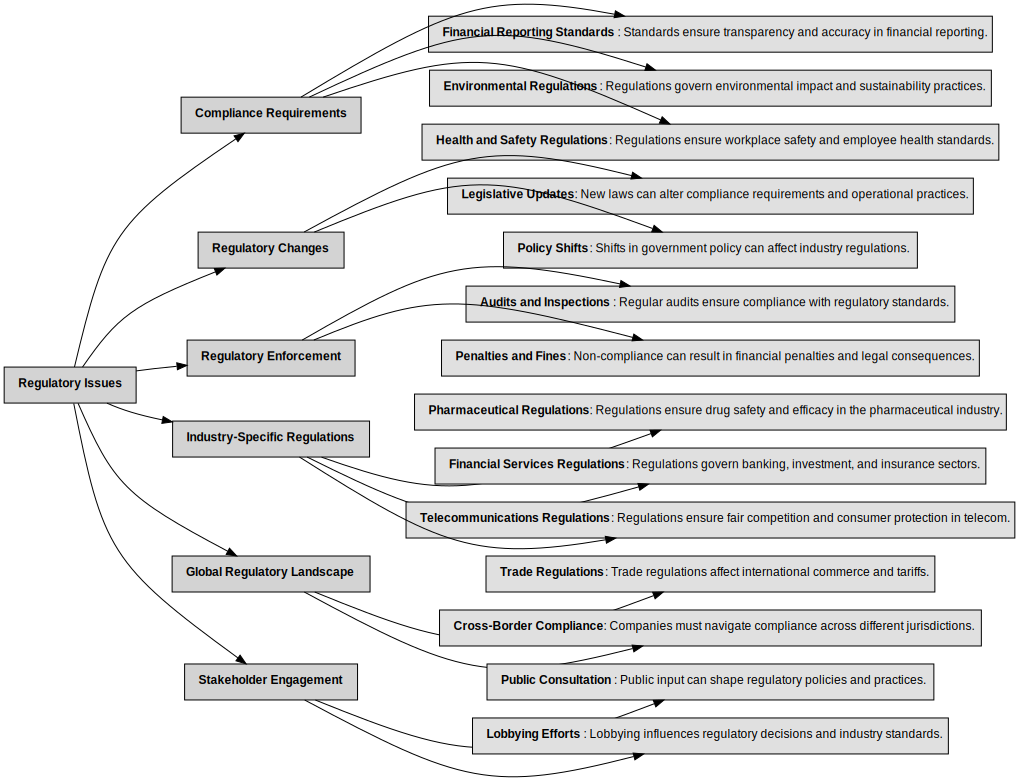

In [31]:
# Generate the Theme Tree
themes_tree_dict = {}
for focus in list_specific_focus:
    theme_tree = generate_theme_tree(
                        main_theme=general_theme,
                        focus=focus
                    )
    themes_tree_dict[focus] = theme_tree

theme_tree.visualize()

The taxonomy tree includes descriptive sentences that explicitly connect each sub-theme back to the **Regulatory Issues** general theme, ensuring all search results remain contextually relevant to our central trend.

### Retrieve Content

With the theme taxonomy and screening parameter you can leverage the Bigdata API to run a search on company news, filings and transcripts.

In [32]:
# Run searches on News, Filings, and Transcripts
df_sentences_news = []
df_sentences_filings = []
df_sentences_transcripts = []

scopes_config = [
    (DocumentType.NEWS, document_limit_news, df_sentences_news, None),
    (DocumentType.FILINGS, document_limit_filings, df_sentences_filings, fiscal_year),
    (DocumentType.TRANSCRIPTS, document_limit_transcripts, df_sentences_transcripts, fiscal_year)
]

# Search using summaries
for scope, document_limit, df_list, year in scopes_config:
    for focus in list_specific_focus:
        df_sentences = search_by_companies(
            companies=companies,
            sentences=list(themes_tree_dict[focus].get_terminal_label_summaries().values()),
            fiscal_year=year,
            start_date=start_date,
            end_date=end_date,
            scope=scope,
            freq=search_frequency,
            document_limit=document_limit,
            batch_size=batch_size
        )
        df_sentences['theme'] = general_theme + ' in ' + focus
        df_list.append(df_sentences)

# Concatenate results
df_sentences_news = pd.concat(df_sentences_news)
df_sentences_filings = pd.concat(df_sentences_filings)
df_sentences_transcripts = pd.concat(df_sentences_transcripts)

Processing transcripts results...: 100%|██████████| 26/26 [00:00<00:00, 28834.45it/s]


In [33]:
df_sentences_news.head(3)

,timestamp_utc,document_id,sentence_id,headline,entity_id,document_type,is_reporting_entity,entity_name,entity_sector,entity_industry,entity_country,entity_ticker,text,other_entities,entities,masked_text,other_entities_map,theme
0,2025-01-01 17:31:08+00:00,B0F11903771481EAFA5351FF5DC2D394,B0F11903771481EAFA5351FF5DC2D394-7,Regulators struggle as 50% of banned UK crypto...,228D42,news,False,Microsoft Corp.,Technology,Software,United States,MSFT,"But while influencers feel the heat, crypto co...",Alphabet Inc.,"[{'key': '228D42', 'name': 'Microsoft Corp.', ...","But while influencers feel the heat, crypto co...","[(1, Alphabet Inc.)]",Regulatory Issues in AI
1,2025-01-01 21:00:22+00:00,DAFB8EE82B29FEE69C4D22E047FF0321,DAFB8EE82B29FEE69C4D22E047FF0321-3,Mexico Announces New Tariffs That Will Impact ...,0157B1,news,False,Amazon.com Inc.,Consumer Services,Internet & Direct Marketing Retail,United States,AMZN,These measures could disrupt Mexico's IMMEX pr...,"Whaleco Inc., Walmart Inc.","[{'key': 'PJOQKD', 'name': 'Whaleco Inc.', 'ti...",These measures could disrupt Mexico's IMMEX pr...,"[(2, Walmart Inc.), (3, Whaleco Inc.)]",Regulatory Issues in AI
2,2025-01-02 14:33:58+00:00,2A00B88E9D31133B5622D9A8E101BFC8,2A00B88E9D31133B5622D9A8E101BFC8-7,13 Easy Ways To Boost Your Savings In 2025 And...,0157B1,news,False,Amazon.com Inc.,Consumer Services,Internet & Direct Marketing Retail,United States,AMZN,You may also share subscriptions with family o...,"The Walt Disney Co., Netflix Inc.","[{'key': '0157B1', 'name': 'Amazon.com Inc.', ...",You may also share subscriptions with family o...,"[(4, The Walt Disney Co.), (5, Netflix Inc.)]",Regulatory Issues in AI


In [34]:
df_sentences_filings.head(3)

,timestamp_utc,document_id,sentence_id,headline,entity_id,document_type,is_reporting_entity,entity_name,entity_sector,entity_industry,entity_country,entity_ticker,text,other_entities,entities,masked_text,other_entities_map,theme
0,2025-01-29 21:11:54+00:00,18C61A771E46659D306162C2EDA9B9C6,18C61A771E46659D306162C2EDA9B9C6-167,"MICROSOFT CORP files FORM 10-Q for Q2, FY 2025...",228D42,filings,True,Microsoft Corp.,Technology,Software,United States,MSFT,"PART II Acquisitions, joint ventures, and stra...","Nuance Communications Inc., Activision Blizzar...","[{'key': 'E5752F', 'name': 'Nuance Communicati...","PART II Acquisitions, joint ventures, and stra...","[(1, OpenAI Inc.), (2, Activision Blizzard Inc...",Regulatory Issues in AI
1,2025-01-29 21:11:54+00:00,18C61A771E46659D306162C2EDA9B9C6,18C61A771E46659D306162C2EDA9B9C6-54,"MICROSOFT CORP files FORM 10-Q for Q2, FY 2025...",228D42,filings,True,Microsoft Corp.,Technology,Software,United States,MSFT,"In 2018, the Irish Data Protection Commission ...","LinkedIn Corp., LinkedIn Corp., LinkedIn Corp....","[{'key': '88598A', 'name': 'LinkedIn Corp.', '...","In 2018, the Irish Data Protection Commission ...","[(4, LinkedIn Corp.), (4, LinkedIn Corp.), (4,...",Regulatory Issues in AI
2,2025-01-29 21:11:54+00:00,18C61A771E46659D306162C2EDA9B9C6,18C61A771E46659D306162C2EDA9B9C6-296,"MICROSOFT CORP files FORM 10-Q for Q2, FY 2025...",228D42,filings,True,Microsoft Corp.,Technology,Software,United States,MSFT,"In April of 2023, the court granted defendants...","LinkedIn Corp., LinkedIn Corp., LinkedIn Corp.","[{'key': '88598A', 'name': 'LinkedIn Corp.', '...","In April of 2023, the court granted defendants...","[(4, LinkedIn Corp.), (4, LinkedIn Corp.), (4,...",Regulatory Issues in AI


In [35]:
df_sentences_transcripts.head(3)

,timestamp_utc,document_id,sentence_id,headline,entity_id,document_type,is_reporting_entity,entity_name,entity_sector,entity_industry,entity_country,entity_ticker,text,other_entities,entities,masked_text,other_entities_map,theme
0,2025-01-29 22:30:00+00:00,0CFCC61996D037CC9983AAE1B1C2F5B5,0CFCC61996D037CC9983AAE1B1C2F5B5-7,Microsoft Corporation: Q2 2025 Earnings Call o...,228D42,transcripts,True,Microsoft Corp.,Technology,Software,United States,MSFT,"From now on, it's a more continuous cycle gove...",,"[{'key': '228D42', 'name': 'Microsoft Corp.', ...","From now on, it's a more continuous cycle gove...",None,Regulatory Issues in AI
1,2025-01-29 22:30:00+00:00,1DF1ADE684D15A8F2B1DE7D0D6B8A406,1DF1ADE684D15A8F2B1DE7D0D6B8A406-16,Microsoft Corporation: Q2 2025 Earnings Call o...,228D42,transcripts,True,Microsoft Corp.,Technology,Software,United States,MSFT,"With Dynamics 365, we took share as organizati...","Vizient Inc., Lenovo Group Ltd.","[{'key': '228D42', 'name': 'Microsoft Corp.', ...","With Dynamics 365, Target Company took share a...","[(1, Vizient Inc.), (2, Lenovo Group Ltd.)]",Regulatory Issues in AI
2,2025-01-29 22:30:00+00:00,49961A1FB47BC7991DC1000E2F165817,49961A1FB47BC7991DC1000E2F165817-7,Microsoft Corp.: Q2 2025 Earnings Call,228D42,transcripts,True,Microsoft Corp.,Technology,Software,United States,MSFT,"Before I get into the details of the quarter, ...",,"[{'key': '228D42', 'name': 'Microsoft Corp.', ...","Before I get into the details of the quarter, ...",None,Regulatory Issues in AI


### Label the Results

Use an LLM to analyze each document chunk and determine its relevance to the main theme. Any document chunks which aren't explicitly linked to **Regulatory Issues** will be filtered out.

In [36]:
# Label the search results with our theme labels
labeler = ScreenerLabeler(llm_model=llm_model)

# Initialize empty lists for labeled data
df_news_labeled = []
df_filings_labeled = []
df_transcripts_labeled = []

# Configure data sources
sources_config = [
    (df_sentences_news, df_news_labeled),
    (df_sentences_filings, df_filings_labeled),
    (df_sentences_transcripts, df_transcripts_labeled)
]

for df_sentences, labeled_list in sources_config:
    for focus in list_specific_focus:
        df_sentences_theme = df_sentences.loc[(df_sentences.theme == general_theme + ' in ' + focus)]
        df_sentences_theme.reset_index(drop=True, inplace=True)
        df_labels = labeler.get_labels(
            main_theme=general_theme + ' in ' + focus,
            labels=list(themes_tree_dict[focus].get_terminal_label_summaries().keys()),
            texts=df_sentences_theme["masked_text"].tolist()
        )
        df_merged_labels = pd.merge(df_sentences_theme, df_labels, left_index=True, right_index=True)
        labeled_list.append(df_merged_labels)

# Concatenate results
df_news_labeled = pd.concat(df_news_labeled)
df_filings_labeled = pd.concat(df_filings_labeled)
df_transcripts_labeled = pd.concat(df_transcripts_labeled)

Querying OpenAI...:   0%|          | 0/3232 [00:00<?, ?it/s]

Querying OpenAI...: 100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


### Document Distribution Visualization

You can visualize the tables showing the count of different document types for each company in the given universe. This helps you understand the distribution and availability of information across different sources for each entity.

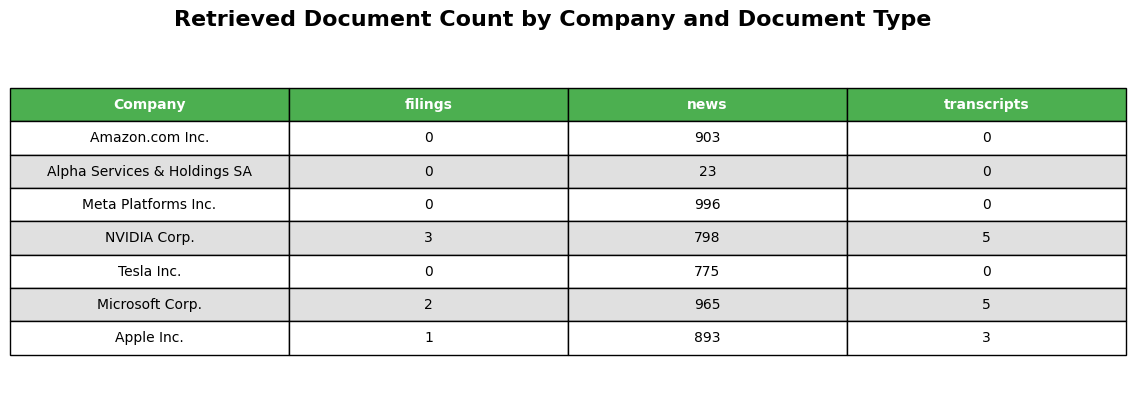

In [37]:
df_statistic_resources = pd.concat([df_news_labeled, df_filings_labeled, df_transcripts_labeled])

create_styled_table(df_statistic_resources,title='Retrieved Document Count by Company and Document Type', companies_list = company_names)

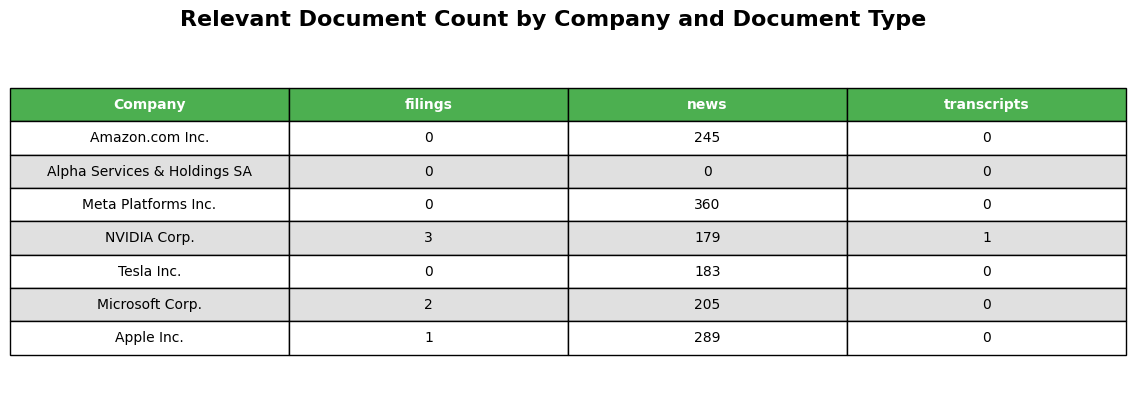

In [38]:
df_statistic_resources_relevant = df_statistic_resources.loc[~df_statistic_resources.label.isin(['', 'unassigned', 'unclear'])]
create_styled_table(df_statistic_resources_relevant, title='Relevant Document Count by Company and Document Type', companies_list = company_names)

### Summarizer

The following code is used to create a summary for each company using the information from the retrieved documents.

In [39]:
# Run the process to summarize the documents and compute media attention by topic, sector-wide
summarizer_sector = TopicSummarizerSector(
   model=llm_model.split('::')[1],
   api_key=OPENAI_API_KEY,
   df_labeled=df_news_labeled,
   general_theme=general_theme,
   list_specific_focus=list_specific_focus,
   themes_tree_dict=themes_tree_dict,
   logger=GenerateReport.logger
)
df_by_theme = summarizer_sector.summarize()

# Run the process to summarize the documents and score media attention, risk and uncertainty by topic at company level
summarizer_company = TopicSummarizerCompany(
   model=llm_model.split('::')[1],
   api_key=OPENAI_API_KEY,
   logger=GenerateReport.logger,
   verbose=True
)
df_by_company = asyncio.run(
   summarizer_company.process_topic_by_company(
       df_labeled=df_news_labeled,
       list_entities=companies
   )
)

2025-07-15 07:49:14,841 - INFO - Preparing topics from the labeled DataFrame
2025-07-15 07:49:14,863 - INFO - Starting processing for 248 tasks...


### Company Response Analysis

Extract company mitigation strategies from filings and transcripts.

In [40]:
# Concatenate Filings and Transcripts dataframes
df_filings_labeled['doc_type'] = 'Filings'
df_transcripts_labeled['doc_type'] = 'Transcripts'
df_ft_labeled = pd.concat([df_filings_labeled, df_transcripts_labeled])
df_ft_labeled = df_ft_labeled.reset_index(drop=True)

# Run the process to extract company's mitigation plan from the documents (filings and transcripts)
response_processor = CompanyResponseProcessor(
   model=llm_model.split('::')[1],
   api_key=OPENAI_API_KEY,
   logger=GenerateReport.logger,
   verbose=True
)


df_response_by_company = asyncio.run(
   response_processor.process_response_by_company(
       df_labeled=df_ft_labeled,
       df_by_company=df_by_company,
       list_entities=companies
   )
)

# Merge the companies responses to the dataframe with issue summaries and scores
df_by_company_with_responses = pd.merge(df_by_company, df_response_by_company, on=['entity_id', 'entity_name', 'topic'], how='left')
df_by_company_with_responses['filings_response_summary'] = df_by_company_with_responses['response_summary']

# Extract the company's mitigation plan for each regulatory issue from the News documents
df_news_response_by_company = asyncio.run(
   response_processor.process_response_by_company(
       df_labeled=df_news_labeled,
       df_by_company=df_by_company,
       list_entities=companies
   )
)

df_news_response_by_company = df_news_response_by_company.rename(
   columns={'response_summary': 'news_response_summary', 'n_response_documents': 'news_n_response_documents'}
)
df_by_company_with_responses = pd.merge(df_by_company_with_responses, df_news_response_by_company,
                                       on=['entity_id', 'entity_name', 'topic'], how='left')
df_by_company_with_responses['response_summary'] = df_by_company_with_responses['response_summary'].fillna(
   df_by_company_with_responses['news_response_summary']
)


report_by_theme = df_by_theme
report_by_company = df_by_company_with_responses

2025-07-15 07:50:01,135 - INFO - Starting process_response_by_company with 32 tasks...
2025-07-15 07:50:01,150 - WARNING - No topic summary present for entity 'NVIDIA Corp.' and topic 'Regulatory Issues in E-commerce - Sector-Specific Licenses'
2025-07-15 07:50:01,296 - WARNING - No topic summary present for entity 'Microsoft Corp.' and topic 'Regulatory Issues in E-commerce - Health and Safety Regulations'
2025-07-15 07:50:01,309 - WARNING - No topic summary present for entity 'Microsoft Corp.' and topic 'Regulatory Issues in Advertising - Trade Regulations'
2025-07-15 07:50:01,314 - WARNING - No topic summary present for entity 'Apple Inc.' and topic 'Regulatory Issues in AI - Financial Reporting Standards'
2025-07-15 07:50:01,320 - WARNING - No topic summary present for entity 'Apple Inc.' and topic 'Regulatory Issues in Hardware and Chips - Financial Reporting Standards'
2025-07-15 07:50:01,325 - WARNING - No topic summary present for entity 'Apple Inc.' and topic 'Regulatory Issue

## Direct method

Once the class `GenerateReport` is initialized you can just run the method `generate_report()` to get the final output and then you can run the functions to visualize the results and to generate the report.

For practical reasons you can also choose to import and/or export the intermediate outputs to/from a specific directory:

- **import_from_path**: File path from where the intermediate outputs will be loaded
- **export_to_path**: File path where the intermediate outputs will be saved

To run the direct method uncomment the variable `DIRECT_METHOD`

To export the intermediate results / final outputs uncomment the variable `EXPORT_RESULTS`

In [41]:
# Uncomment the flag DIRECT_METHOD to run the workflow
#DIRECT_METHOD_FLAG = True
#EXPORT_RESULTS_FLAG = True

if 'DIRECT_METHOD_FLAG' in globals() and DIRECT_METHOD_FLAG:
  if 'EXPORT_RESULTS_FLAG' in globals() and EXPORT_RESULTS_FLAG:
    report = report_generator.generate_report(import_from_path=output_dir, export_to_path=output_dir)
  else:
    report = report_generator.generate_report()

  themes_tree_dict=report.themes_tree_dict
  df_by_theme=report.report_by_theme
  df_by_company_with_responses=report.report_by_company

## Generate Final Report
Rank the topics based on their **Media Attention**, **Risk/Financial Impact**, and **Uncertainty**.


You can customize the ranking system by specifying the number of top themes to display (user_selected_nb_topics_themes).

The report will provide a detailed analysis of individual companies, highlighting three key aspects:
1. **Most Reported Issue**
2. **Biggest Risk**
3. **Most Uncertain Issue**

Each aspect is analyzed using its own ranking system, allowing for a tailored and detailed view of company-specific topics.

In [42]:
# generate the html report
top_by_theme, top_by_company = prepare_data_report_0(
     df_by_theme = df_by_theme,
     df_by_company_with_responses = df_by_company_with_responses,
     user_selected_nb_topics_themes = 3,
)

html_content = generate_html_report(top_by_theme, top_by_company, 'Regulatory Issues in the Tech Sector')

with open(output_dir+'/report.html', 'w') as file:
     file.write(html_content)

display(HTML(html_content))

## Export the Results

Export the data as Excel files for further analysis or to share with the team.

In [ ]:
try:
    # Create the Excel manager
    excel_manager = ExcelManager()

    # Define the dataframes and their sheet configurations
    df_args = [
        (df_by_company_with_responses, "Report Regulatory Issues by companies", (2, 3)),
        (df_by_theme, "Report Regulatory Issues by theme", (1, 1))
    ]

    # Save the workbook
    excel_manager.save_workbook(df_args, export_path)

except Exception as e:
    print(f"Warning while exporting to excel: {e}")



In [44]:
print("Runtime:", datetime.now() - start)

Runtime: 0:46:59.588172
